In [16]:
import os
import pandas as pd
import numpy as np
import csv
import os
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

os.chdir('/root/CIFAR-100-Dataset')
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_set=unpickle('train')
test_set=unpickle('test')
meta_set=unpickle('meta')

train_set_dict_keys= train_set.keys()
meta_set_dict_keys=meta_set.keys()
print(train_set_dict_keys, meta_set_dict_keys)
print(len(train_set[b'data']), len(train_set[b'batch_label']), len(train_set[b'fine_labels']), len(train_set[b'coarse_labels']), len(train_set[b'filenames']))
print(len(test_set[b'data']), len(test_set[b'batch_label']), len(test_set[b'fine_labels']), len(test_set[b'coarse_labels']), len(test_set[b'filenames']))
print(len(meta_set[b'fine_label_names']), len(meta_set[b'coarse_label_names']))

print(len(set(train_set[b'fine_labels'])), len(set(train_set[b'coarse_labels'])))
print(len(set(test_set[b'fine_labels'])), len(set(test_set[b'coarse_labels'])))

x_train=train_set[b'data']
x_test=test_set[b'data']
y_train=np.array(train_set[b'coarse_labels'])
y_test=np.array(test_set[b'coarse_labels'])

#cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
#Y_train_all_attacks.replace(cleanup_nums,inplace=True)
#Y_test_all_attacks.replace(cleanup_nums,inplace=True)

dict_keys([b'coarse_labels', b'batch_label', b'filenames', b'fine_labels', b'data']) dict_keys([b'coarse_label_names', b'fine_label_names'])
50000 21 50000 50000 50000
10000 20 10000 10000 10000
100 20
100 20
100 20


In [17]:
type(x_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [21]:
%load_ext autoreload
%autoreload 2
%pylab inline

os.chdir('/root/pathint/fig_split_mnist')

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive', 'pylab', 'select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [52]:
# Data params
input_dim = 3072
output_dim = 20

# Network params
n_hidden_units = 1000
activation_fn = tf.nn.relu

# Optimization params
batch_size = 100
epochs_per_task = 20

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

In [53]:
from keras.utils import np_utils

task_labels = [[0,1,2,3], [4,5,6,7], [8,9,10], [11,12,13,14], [15,16,17],[18,19]]
#task_labels = [[4,2], [0,6], [3,8], [9,7], [1,5],[8,9],[6,7],[5,5],[3,2],[0,1]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[0,9],[3,8],[0,6],[4,2],[3,5],[0,4],[9,6],[1,2]]
n_tasks = len(task_labels)
nb_classes  = 20
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_train[idx], np_utils.to_categorical(label_map[y_train[idx]], len(labels))
    else:
        data = x_train[idx], np_utils.to_categorical(y_train[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(y_test, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_test[idx], np_utils.to_categorical(label_map[y_test[idx]], len(labels))
    else:
        data = x_test[idx], np_utils.to_categorical(y_test[idx], nb_classes)
        validation_datasets.append(data)

In [54]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [55]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
model = Sequential()
model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))
#model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax, input_shape=(input_dim,)))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
#opt = SGD(1e-3)
#opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
#history = History()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

In [56]:
print(protocol)

{'regularizer_fn': <function quadratic_regularizer at 0x7f98a223f488>, 'step_updates': [('grads2', <function <lambda>.<locals>.<lambda> at 0x7f97611082f0>)], 'task_updates': [('omega', <function <lambda>.<locals>.<lambda> at 0x7f9761108bf8>), ('cweights', <function <lambda>.<locals>.<lambda> at 0x7f9761108e18>), ('grads2', <function <lambda>.<locals>.<lambda> at 0x7f9761108b70>)], 'init_updates': [('cweights', <function <lambda>.<locals>.<lambda> at 0x7f9761108a60>)]}


In [57]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    imp_par = dict()  #Empty list to save importance parameter after learning each progressive task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[print_weights])
                save_loss_epoch.append(stuffs.history['loss'])
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save, imp_par

In [58]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [0, 1.0]
print(cvals)

[0, 1.0]


In [59]:
#%%capture

recompute_data = True

if recompute_data:
    data,model_weights_save,imp_par = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/2 [00:00<?, ?it/s]

setting cval
cval is 0.0
Age 0, cval is=0.000000
settint output mask
Epoch 1/20
10000/10000 [==============================] - 6s - loss: 12.0780 - acc: 0.2506     
Epoch 2/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 3/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 4/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 5/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 6/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 7/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 8/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 9/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 10/20
10000/10000 [==============================] - 6s - los

7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 4/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 5/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 6/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 7/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 8/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 9/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 10/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 11/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 12/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 13/20
7500/7500 [==============================] - 4s - loss: 

 50%|█████     | 1/2 [11:04<11:04, 664.69s/it]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/20
10000/10000 [==============================] - 6s - loss: 12.0901 - acc: 0.2494     
Epoch 2/20
10000/10000 [==============================] - 6s - loss: 12.0887 - acc: 0.2499     
Epoch 3/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 4/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 5/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 6/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 7/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 8/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 9/20
10000/10000 [==============================] - 6s - loss: 12.0886 - acc: 0.2500     
Epoch 10/20
10000/10000 [==============================] - 6s - los

7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 4/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 5/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 6/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 7/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 8/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 9/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 10/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 11/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 12/20
7500/7500 [==============================] - 4s - loss: 10.7454 - acc: 0.3333     
Epoch 13/20
7500/7500 [==============================] - 4s - loss: 

100%|██████████| 2/2 [22:07<00:00, 663.74s/it]


In [48]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

#a_list[0][0][0] = a_list[0][0][0]+0.00001
#print(a_list[0][0][0])
#model.set_weights(a_list)

#from keras.utils.vis_utils import plot_model
#import pydot
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 20)                20020     
Total params: 4,094,020
Trainable params: 4,094,020
Non-trainable params: 0
_________________________________________________________________
None
(3072, 1000)
(1000,)
(1000, 1000)
(1000,)
(1000, 20)
(20,)


In [49]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[0, 1.0]


In [140]:
print(data['mean'])
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0

{1.0: array([[0.89707047, 0.72999353, 0.85853499, 0.64988939, 0.53443673,
        0.058653  , 0.83987661, 0.84052575, 0.9960624 , 0.7922204 ],
       [0.89707047, 0.84221925, 0.82854393, 0.31596469, 0.53577149,
        0.058653  , 0.75778183, 0.96976414, 0.9419503 , 0.7922204 ],
       [0.89707047, 0.80579327, 0.30259178, 0.64986749, 0.53390283,
        0.05870477, 0.70386988, 0.96976414, 0.94108523, 0.87873086],
       [0.89707047, 0.80902679, 0.30259178, 0.7313884 , 0.56807261,
        0.05870477, 0.14021312, 0.96976414, 0.99612207, 0.8803153 ],
       [0.89707047, 0.80856056, 0.30259178, 0.7313884 , 0.56700481,
        0.05870477, 0.14021312, 0.96976414, 0.99612207, 0.88043414],
       [0.45288994, 0.80615422, 0.30247147, 0.7313884 , 0.56700481,
        0.94108816, 0.14021312, 0.96772071, 0.99612207, 0.88051336],
       [0.45288994, 0.8019732 , 0.30247147, 0.70484263, 0.46609717,
        0.94108816, 0.78568424, 0.96515776, 0.99612207, 0.88079064],
       [0.45288994, 0.84221925, 0.3

In [50]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5.0, 0.0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


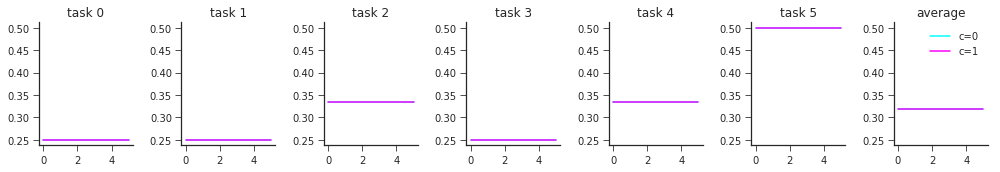

In [51]:
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('2Attack_Accuracy_10task.pdf')

In [34]:
for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
       print(mean_vals[:, j],std_vals[:, j]/np.sqrt(n_stats))

[0.89707047 0.89707047 0.89707047 0.89707047 0.89707047 0.10292953
 0.10292953 0.10292953 0.89707047 0.89707047] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.21184822 0.84221925 0.84221925 0.84221925 0.84221925 0.84221925
 0.84221925 0.84221925 0.84221925 0.86849348] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.68754297 0.10867249 0.30274646 0.30272927 0.30272927 0.30293551
 0.30293551 0.30293551 0.30293551 0.30302145] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.73149791 0.7313884  0.7313884  0.66990823 0.66990823 0.66990823
 0.656263   0.6553212  0.66114725 0.66178242] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.53470368 0.56326749 0.56567005 0.56326749 0.56940737 0.56940737
 0.46609717 0.48478377 0.48478377 0.48478377] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.058653   0.058653   0.90826733 0.90821556 0.90821556 0.941347
 0.941347   0.941347   0.941347   0.941347  ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.14329781 0.21662928 0.21655917 0.66727426 0.66832586 0.66825575
 0.73058048 0.73114133 0.73121144 0.73142176] [0. 0. 0. 0. 0. 0. 

In [35]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


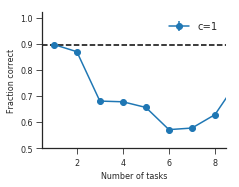

In [36]:
#Fractional Correctness = Average of cross validation accuracies of learned tasks only after training each task 
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0.5, 8.5)
ylim(0.5, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('2attack_fractional_correct_UNSW.pdf')

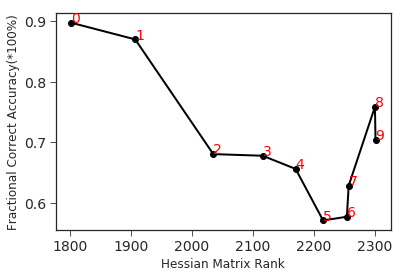

[0.897070467141726, 0.8696448574297311, 0.6806787247890768, 0.6779818040652222, 0.6562669168239876, 0.5714578153590283, 0.5774817075388184, 0.6288052173267944, 0.7585112106308061, 0.7044394974891064]


In [37]:
import matplotlib     
matplotlib.rc('xtick', labelsize=14)     
matplotlib.rc('ytick', labelsize=14)
Hess_rank=[1802, 1907, 2035, 2116, 2170, 2215, 2254, 2257, 2300, 2301] #calculated previously
plt.plot(Hess_rank,mean_stuff,'ko-', linewidth=2)
for i,j,k in zip(Hess_rank,mean_stuff,range(n_tasks)):
    plt.annotate(str(k),xy=(i,j),color='r', fontsize=14)
plt.xlabel('Hessian Matrix Rank',fontsize=12)
plt.ylabel('Fractional Correct Accuracy(*100%)',fontsize=12)
plt.savefig('Fractioncorrect-Hessian-UNSW.pdf')
plt.show()
print(mean_stuff)

In [19]:
import pandas as pd
from numpy.linalg import matrix_rank
import math
corr_matrix = []
corr_row = []
Rank_corr_matrix=[]
for j in range(n_tasks):
    df = pd.DataFrame(training_datasets[j][0])
    correlation_matrix = df.corr().values
    correlation_matrix = np.nan_to_num(correlation_matrix)
    for k in range(len(correlation_matrix)):
        for i in range(len(correlation_matrix)):
            corr_elem = (math.ceil(correlation_matrix[k][i]*1e10)/1e10)
            corr_row.append(np.around(corr_elem))
        corr_matrix.append(corr_row)
        corr_row = []
    rank_corr_matrix=np.linalg.matrix_rank(np.asarray(corr_matrix))
    Rank_corr_matrix.append(rank_corr_matrix)
    print('Rank of the Autocorrelation Matrix for task=',j,'is :',rank_corr_matrix)

Rank of the Autocorrelation Matrix for task= 0 is : 24
Rank of the Autocorrelation Matrix for task= 1 is : 36
Rank of the Autocorrelation Matrix for task= 2 is : 36
Rank of the Autocorrelation Matrix for task= 3 is : 38
Rank of the Autocorrelation Matrix for task= 4 is : 39
Rank of the Autocorrelation Matrix for task= 5 is : 39
Rank of the Autocorrelation Matrix for task= 6 is : 39
Rank of the Autocorrelation Matrix for task= 7 is : 40
Rank of the Autocorrelation Matrix for task= 8 is : 41
Rank of the Autocorrelation Matrix for task= 9 is : 41


In [23]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+50 
for i in range(n_tasks):   
    Extract_model_params.append(Flatten_weights[i])

In [40]:
len(save_weights_epoch),len(model_weights_save)

(100, 10)

In [52]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    if i == 0:
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-2])))
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-1])))
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+80 
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    if i == 2:
        pass
    else :
        temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
        gradient = [j/0.001 for j in temp]
        gradient_save.append(gradient)
    
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
    rank_Hessian_matrix = np.linalg.matrix_rank(np.asarray(Hessian_matrix))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 854
Rank of the Hessian Matrix after task= 1 is : 1661
Rank of the Hessian Matrix after task= 2 is : 1774
Rank of the Hessian Matrix after task= 3 is : 1948
Rank of the Hessian Matrix after task= 4 is : 1993
Rank of the Hessian Matrix after task= 5 is : 2034
Rank of the Hessian Matrix after task= 6 is : 2065
Rank of the Hessian Matrix after task= 7 is : 2085
Rank of the Hessian Matrix after task= 8 is : 2099
Rank of the Hessian Matrix after task= 9 is : 2104


In [88]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
                
for i in range(n_tasks):
    Flatten_weights.append(list(flatten(save_weights_epoch[(i+1)*epochs_per_task-2])))
    Flatten_weights.append(list(flatten(save_weights_epoch[(i+1)*epochs_per_task-1])))

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+80 
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params),2):
    temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
    
    gradient = [j/0.001 for j in temp]
    gradient_save.append(gradient)
    
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
    rank_Hessian_matrix = np.linalg.matrix_rank(np.asarray(Hessian_matrix))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 932
Rank of the Hessian Matrix after task= 1 is : 1737
Rank of the Hessian Matrix after task= 2 is : 1800
Rank of the Hessian Matrix after task= 3 is : 1870
Rank of the Hessian Matrix after task= 4 is : 1902
Rank of the Hessian Matrix after task= 5 is : 1967
Rank of the Hessian Matrix after task= 6 is : 2071
Rank of the Hessian Matrix after task= 7 is : 2117
Rank of the Hessian Matrix after task= 8 is : 2130
Rank of the Hessian Matrix after task= 9 is : 2134


In [24]:
#Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
#2. Manhattan Distance
def manhattan_distance(x,y):
    return sum(abs(a-b) for a,b in zip(x,y))
#3.  Minkowski distance 
from decimal import Decimal
def nth_root(value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
def minkowski_distance(x,y,p_value):
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)
#4. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)
#5. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
#6. Using Heuristic    
import difflib 

for i in [0,1,2,3,4,5,6,7,8]:
    print("Eucledian Parameter shift after task {0} :".format(i+1),euclidean_distance(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Cosine Parameter shift after task {0} :".format(i+1),cosine_similarity(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Jaccard Parameter shift after task {0} :".format(i+1),jaccard_similarity(Extract_model_params[i],Extract_model_params[i+1]))
for i in [0,1,2,3,4,5,6,7,8]:
    print("Heuristic Parameter shift after task {0} :".format(i+1),difflib.SequenceMatcher(None,Extract_model_params[i],Extract_model_params[i+1]).ratio())

Eucledian Parameter shift after task 1 : 18.42116476268859
Eucledian Parameter shift after task 2 : 9.208601450530098
Eucledian Parameter shift after task 3 : 3.934590313084037
Eucledian Parameter shift after task 4 : 0.7763082720953064
Eucledian Parameter shift after task 5 : 2.4158320680373264
Eucledian Parameter shift after task 6 : 2.6746329869635184
Eucledian Parameter shift after task 7 : 5.5886347410127915
Eucledian Parameter shift after task 8 : 3.289132188129787
Eucledian Parameter shift after task 9 : 3.2878901208808284
Cosine Parameter shift after task 1 : 0.132
Cosine Parameter shift after task 2 : 0.891
Cosine Parameter shift after task 3 : 0.981
Cosine Parameter shift after task 4 : 0.999
Cosine Parameter shift after task 5 : 0.993
Cosine Parameter shift after task 6 : 0.992
Cosine Parameter shift after task 7 : 0.966
Cosine Parameter shift after task 8 : 0.989
Cosine Parameter shift after task 9 : 0.989
Jaccard Parameter shift after task 1 : 0.16968781470292044
Jaccard P

In [44]:
#Counting the number of changed parameters
changed_model_parameters=[]
for i in range(1,len(Extract_model_params)):
    temp=[]
    for j,k in zip(Extract_model_params[i],Extract_model_params[i-1]):
        temp.append(abs(i-j))
    changed_model_parameters.append(temp)
print(len(changed_model_parameters))

import csv
#Save the model parameters in text file
with open('temp', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(Extract_model_params)

4


In [51]:
#Number of parameters unchanged within the thresold. Checked for five threshold values as [1e-5, 1e-4, 1e-3, 1e-2, 1e-1].
for i in range(len(changed_model_parameters)):
    print('-----After learning',i+2,'task-----')
    for j in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
        print(j,'---->',sum(k < j for k in changed_model_parameters[i]))

-----After learning 2 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 1
0.1 ----> 14
-----After learning 3 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 0
-----After learning 4 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 1
-----After learning 5 task-----
1e-05 ----> 0
0.0001 ----> 0
0.001 ----> 0
0.01 ----> 0
0.1 ----> 1


In [25]:
#Saving the parameters for future use
import pickle
with open("UNSW_Parameters.txt", "wb") as fp:   #Pickling
    pickle.dump(model_weights_save, fp)
    
with open("UNSW_Parameters.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)